In [1]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

def remove_duplicates(text):
    # Remove special characters and split the text into words
    words = re.findall(r'\b\w+\b', text)
    unique_words = []
    for word in words:
        if word not in unique_words:
            unique_words.append(word.lower())
    return ' '.join(unique_words)

data = pd.read_json('./data/youtube_history.json')
data = data.drop(columns=['url', 'visit_count', 'last_visit_time', 'publishedAt', 'description', 'channelTitle', 'channelId'])
data['tags'] = data['tags'].fillna('').apply(lambda x: list(set(x))).apply(lambda x: ' '.join(map(str, x))).apply(lambda x: x.strip())

data['tags'] = data['tags'].apply(remove_duplicates)
data['title'] = data['title'].apply(remove_duplicates)

data['text'] = data['title'] + ' ' + data['tags']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2810 entries, 0 to 2809
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   2810 non-null   object
 1   tags    2810 non-null   object
 2   text    2810 non-null   object
dtypes: object(3)
memory usage: 66.0+ KB


In [2]:
# Create a TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['text'])

topic_count = 5

# Use Non-negative Matrix Factorization (NMF) to extract topics
nmf = NMF(n_components=topic_count, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

# Get the topic assignments for each row
topic_assignments = W.argmax(axis=1)

# Count the number of rows matched to each topic
topic_counts = [sum(topic_assignments == i) for i in range(topic_count)]

data['first_topic_id'] = topic_assignments

# Print the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(H):
    topic_words = " ".join([feature_names[i] for i in topic.argsort()[:-21:-1]])
    print(f"Topic[{topic_idx}] {topic_counts[topic_idx]} matches: {topic_words}")

print()
data.info()

Topic[0] 316 matches: fantasy map maps drawing draw cartography mountains tutorial making world building step mpa finish campaign beginner easy start procreate tabletop
Topic[1] 418 matches: comic book conservation books comics age cleaning cgc restoration pressing golden results wet clean label paper press purple removal tutorial
Topic[2] 218 matches: dcs dogfight eagle mirage military combat air viper 22 raptor hornet navy tomcat force army f22 14 f35 wwii bfm
Topic[3] 835 matches: dnd dragons dungeons dm rpg ttrpg dungeon tabletop game master screen role gaming 5e dice roleplaying tips table pathfinder games
Topic[4] 1023 matches: web programmer programming development software engineer engineering developer humor design ai reacts prime open javascript source theo tutorial python typescript

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2810 entries, 0 to 2809
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 


In [26]:
# Create a list to store the top words for each topic
top_words_list = []

# Print the items for each topic
for topic_idx, topic in enumerate(H):
    topic_words = [feature_names[i] for i in topic.argsort()[:-21:-1]]
    top_words_list.append(" ".join(topic_words))


data['top_words'] = [top_words_list[i] for i in topic_assignments]

#data.iloc[2805]['top_words']
#data.style.set_properties(**{'text-align': 'left'}).set_table_styles([ dict(selector='th', props=[('text-align', 'left')] ) ])

topic_four = data[data['first_topic_id'] == 4]
topic_four.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1023 entries, 0 to 2809
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           1023 non-null   object
 1   tags            1023 non-null   object
 2   text            1023 non-null   object
 3   first_topic_id  1023 non-null   int64 
 4   top_words       1023 non-null   object
dtypes: int64(1), object(4)
memory usage: 48.0+ KB


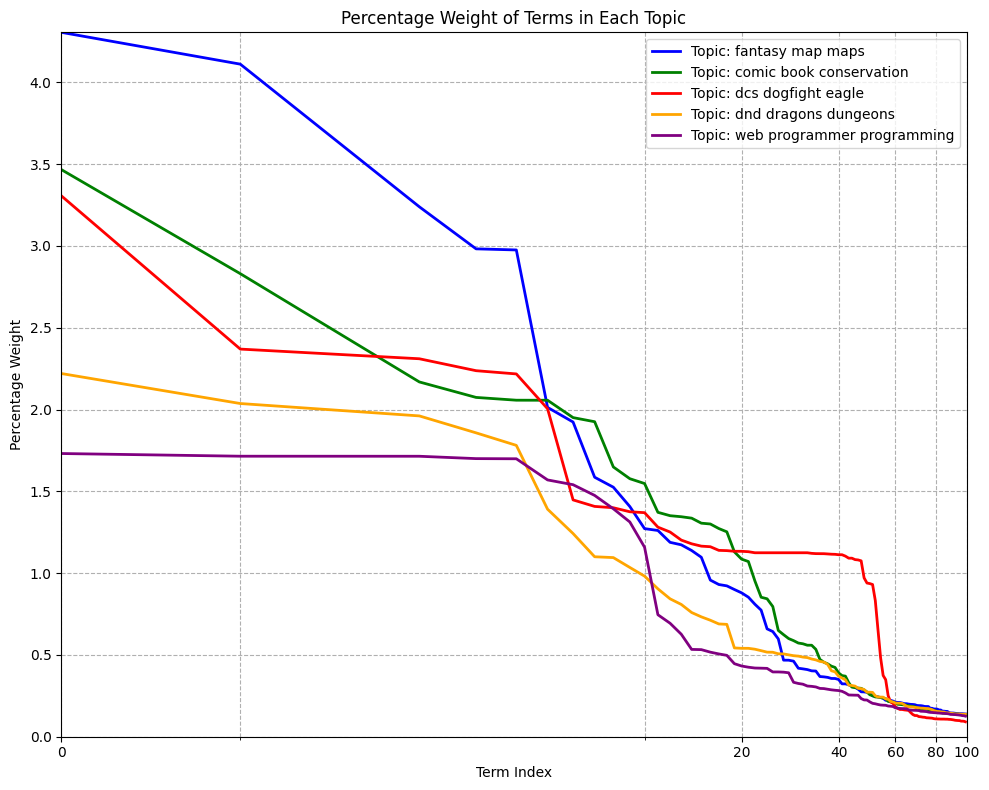

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Define colors for each topic
colors = ['blue', 'green', 'red', 'orange', 'purple']

max_weight = 0

topic_words_list = []

# Plot the percentage weights for each term in each topic
for topic_idx, topic in enumerate(H):
    topic_weights = topic[topic.argsort()[:-101:-1]] / topic.sum() * 100  # Normalizing weights and converting to percentage
    topic_words_list.append(" ".join([feature_names[i] for i in topic.argsort()[:-4:-1]]))
    max_weight = max(max_weight, max(topic_weights))
    x_pos = np.arange(len(topic_weights))
    ax.plot(x_pos, topic_weights, color=colors[topic_idx], linewidth=2, label=f"Topic: {topic_words_list[topic_idx]}")

ax.set_xlabel('Term Index')
ax.set_ylabel('Percentage Weight')
ax.set_title('Percentage Weight of Terms in Each Topic')
ax.set_xscale('symlog')  # Set x-axis to logarithmic scale
ax.set_xticks(np.arange(0, 101, 20))  # Set x-ticks to whole integers from 0 to 100
ax.set_xlim(0, 100)
ax.set_ylim(0, max_weight)   # Set y-axis limit to 0-100
ax.grid(True, which="both", ls="--")  # Add gridlines
ax.legend()

# Prevent scientific notation on the x-axis
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.tight_layout()
plt.show()


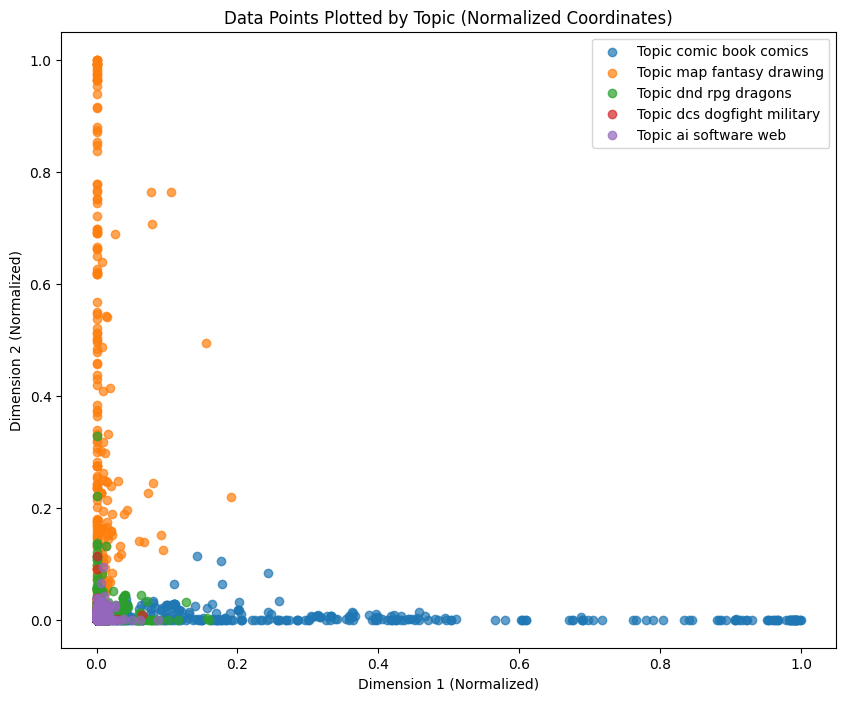

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already performed the NMF topic modeling
# and have the topic assignments for each row in the dataframe

# Create a 2D array of the data points, where each row represents a data point
# and the columns represent the coordinates in the 2D space
X_2d = W[:, :2]  # Use the first two columns of the W matrix as the 2D coordinates

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

topic_labels = []
for topic_idx, topic in enumerate(H):
    topic_labels.append(" ".join([feature_names[i] for i in topic.argsort()[:-4:-1]]))
    
# Normalize the 2D coordinates to the range [0, 1]
X_2d_norm = (X_2d - X_2d.min(axis=0)) / (X_2d.max(axis=0) - X_2d.min(axis=0))

# Plot the data points, coloring them by their topic assignment
for topic_idx in range(topic_count):
    topic_indices = np.where(topic_assignments == topic_idx)[0]
    ax.scatter(X_2d_norm[topic_indices, 0], X_2d_norm[topic_indices, 1], label=f"Topic {topic_words_list[topic_idx]}", alpha=0.7)

# Add labels and title
ax.set_xlabel("Dimension 1 (Normalized)")
ax.set_ylabel("Dimension 2 (Normalized)")
ax.set_title("Data Points Plotted by Topic (Normalized Coordinates)")
ax.legend()

# Display the plot
plt.show()

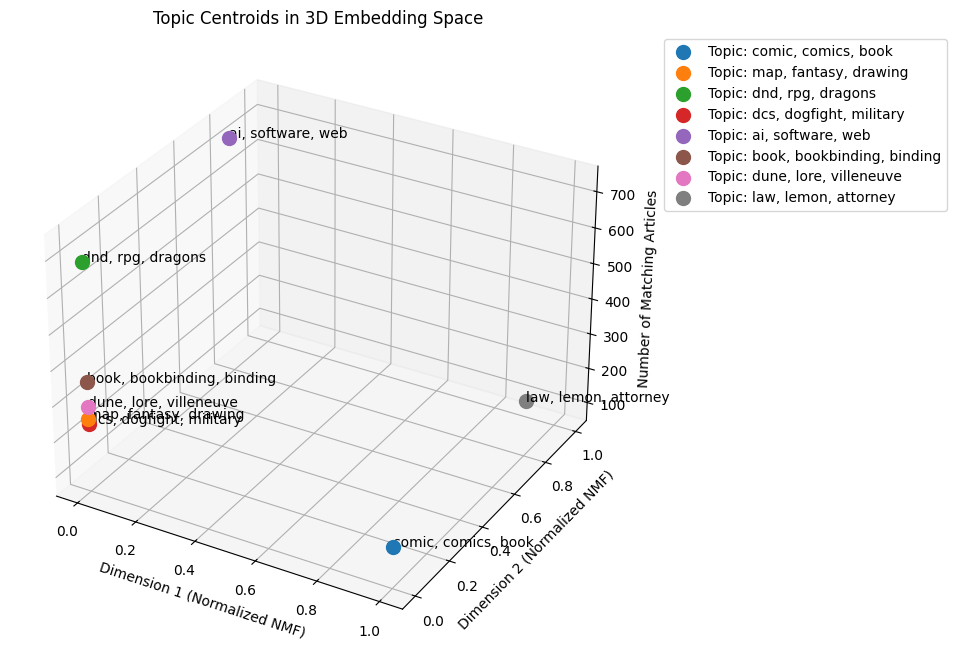

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

# Assuming you have already performed the NMF topic modeling
# and have the topic assignments and topic counts for each row in the dataframe

# Get the top words for each topic
feature_names = vectorizer.get_feature_names_out()
topic_centroids = []
topic_words_list = []
for topic_idx, topic in enumerate(H):
    topic_words = [feature_names[i] for i in topic.argsort()[:-16:-1]][:3]
    topic_words_list.append(", ".join(topic_words))
    topic_centroid = np.mean([vectorizer.transform([word]).toarray() for word in topic_words], axis=0)
    topic_centroids.append(topic_centroid)

# Create a 3D array of the topic centroids
topic_centroids_3d = np.zeros((len(topic_centroids), 3))
topic_centroids_3d[:, :2] = (W[:len(topic_centroids), :2] - W[:len(topic_centroids), :2].min(axis=0)) / (W[:len(topic_centroids), :2].max(axis=0) - W[:len(topic_centroids), :2].min(axis=0))
topic_centroids_3d[:, 2] = topic_counts[:len(topic_centroids)]

# Create a figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the topic centroids
for topic_idx, centroid in enumerate(topic_centroids_3d):
    ax.scatter(centroid[0], centroid[1], centroid[2], label=f"Topic: {topic_words_list[topic_idx]}", s=100)
    ax.text(centroid[0], centroid[1], centroid[2], f"{topic_words_list[topic_idx]}", fontsize=10)

# Add labels and title
ax.set_xlabel("Dimension 1 (Normalized NMF)")
ax.set_ylabel("Dimension 2 (Normalized NMF)")
ax.set_zlabel("Number of Matching Articles")
ax.set_title("Topic Centroids in 3D Embedding Space")
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Display the plot
plt.show()

Get the top words for each topic
Calculate the topic-topic similarity matrix
Create a graph from the topic similarity matrix
Cluster the topics using hierarchical clustering
Visualize the topic similarity graph with cluster assignments


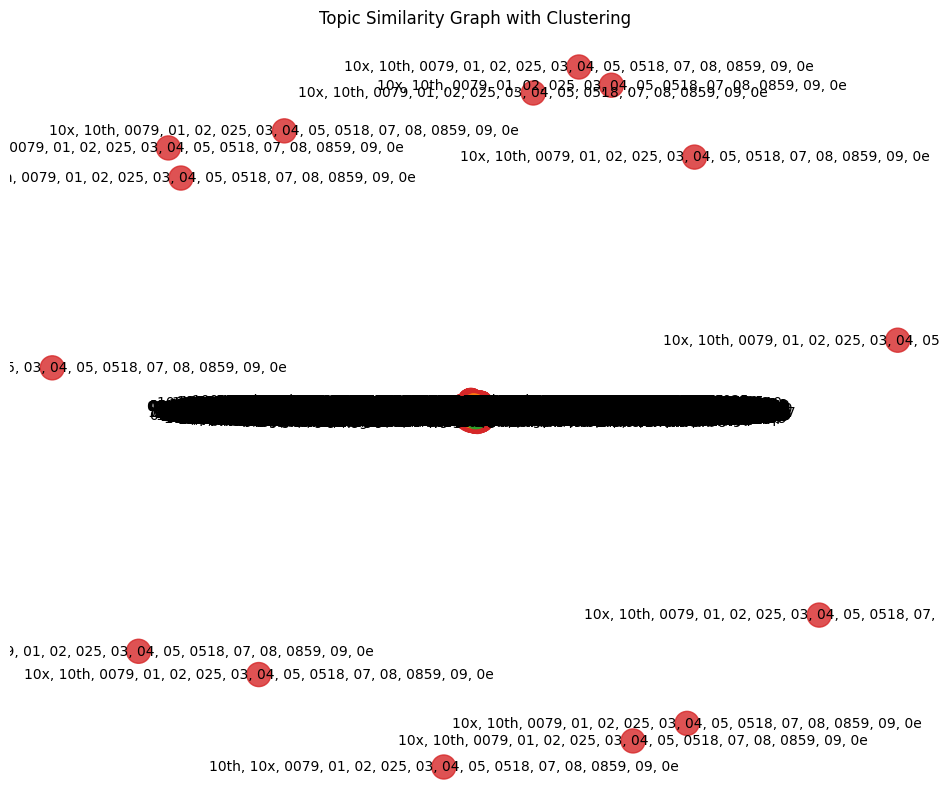

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster

# Assuming you have already performed the NMF topic modeling
# and have the topic assignments and topic counts for each row in the dataframe

print("Get the top words for each topic")
# Get the top words for each topic
feature_names = vectorizer.get_feature_names_out()
topic_words = []
for topic_idx, topic in enumerate(H.T):
    topic_words.append([feature_names[i] for i in topic.argsort()[:-16:-1]])

print("Calculate the topic-topic similarity matrix")
topic_similarity_matrix = cosine_similarity(H.T)

print("Create a graph from the topic similarity matrix")
G = nx.Graph()
for i in range(topic_similarity_matrix.shape[0]):
    G.add_node(i, label=", ".join(topic_words[i]))

print("Add edges between topics with similarity greater than 0.5")
for i in range(topic_similarity_matrix.shape[0]):
    for j in range(i+1, topic_similarity_matrix.shape[0]):
        if topic_similarity_matrix[i, j] > 0.5:
            G.add_edge(i, j, weight=topic_similarity_matrix[i, j])

print("Use the linkage function to create the hierarchical clustering")
linkage_matrix = linkage(topic_similarity_matrix, 'ward')

print("Use the fcluster function to assign each topic to a cluster")
topic_clusters = fcluster(linkage_matrix, 3, criterion='maxclust')

print("Visualize the topic similarity graph with cluster assignments")
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_color=[f'C{i}' for i in topic_clusters], alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=2)
nx.draw_networkx_labels(G, pos, labels={node: G.nodes[node]['label'] for node in G.nodes()}, font_size=10)
plt.title('Topic Similarity Graph with Clustering')
plt.axis('off')
plt.show()

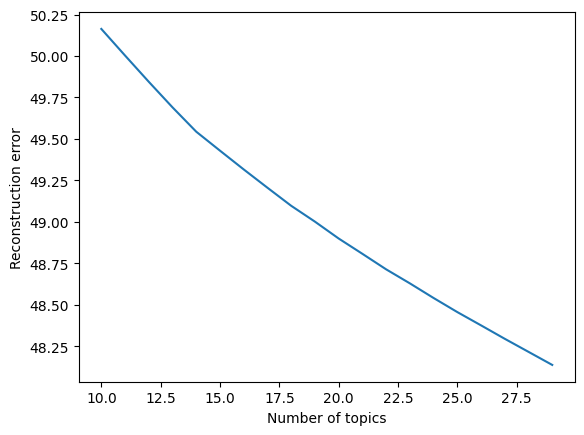

In [ ]:
from sklearn.decomposition import NMF

# Try different numbers of topics
topic_nums = range(10, 30)
reconstruction_errors = []

for n_topics in topic_nums:
    nmf = NMF(n_components=n_topics, random_state=42,)
    W = nmf.fit_transform(X)
    reconstruction_errors.append(nmf.reconstruction_err_)

import matplotlib.pyplot as plt
plt.plot(topic_nums, reconstruction_errors)
plt.xlabel("Number of topics")
plt.ylabel("Reconstruction error")
plt.show()

[nltk_data] Downloading package punkt to /home/anvil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/dependencies/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/dependencies/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


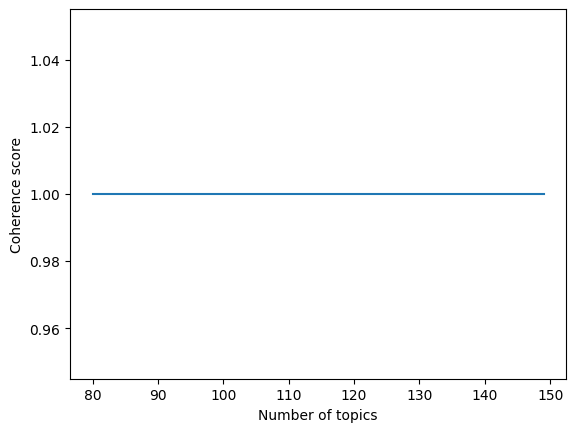

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

data['tokens'] = data['text'].apply(word_tokenize)

# Create a dictionary from the tokenized text
dictionary = Dictionary(data['tokens'].tolist())

coherence_scores = []

for n_topics in topic_nums:
    nmf = NMF(n_components=n_topics, random_state=42)
    W = nmf.fit_transform(X)
    coherence_model = CoherenceModel(topics=H, texts=data['text'], dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

plt.plot(topic_nums, coherence_scores)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.show()

In [ ]:
# Determine the user's preferred topics
user_topic_prefs = reversed(W[0].argsort()[-3:]) 

print("\nUser's preferred topics:")
for topic_idx in user_topic_prefs:
    print(f"Topic {topic_idx}: {' '.join([feature_names[i] for i in H[topic_idx].argsort()[:-11:-1]])}")


User's preferred topics:
Topic 4: ai software web agents engineer engineering development programming crewai programmer
Topic 3: dcs dogfight military war world viper air 22 raptor hornet
Topic 2: dnd rpg dragons dungeons dm dice master dungeon table ttrpg
